Johny Ijaq  
Data Sprint #15

# COVID-19 X-ray Dataset

**Introduction**
Recent findings obtained using radiology imaging techniques suggest that such images contain salient information about the COVID-19 virus. Application of advanced artificial intelligence (AI) techniques coupled with radiological imaging can be helpful for the accurate detection of this disease, and can also be assistive to overcome the problem of a lack of specialized physicians in remote villages. [source of information: ncbi]

**Objective**
X-ray images of patients were given. Objective is to build a machine learning model that will analyze and detect if the patient is a COVID (i.e. the target value as 1) patient or Non-COVID (i.e. the target value as 0) patient.

### Data Description

The training dataset contains X-ray and CT scan images of patients with positive Corona test and negative Corona test. 

**Dataset Link:** https://drive.google.com/file/d/1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr/view?usp=sharing

From the above link you will be able to download a zip file named ‘covid_image_data.zip’. After you extract this zip file, you will get four files:

**train** - contains all the x-ray images of covid and non-covid patient that are to be used for training your model.  Each image has a unique name.

**Training_set_covid.csv** - this csv file contains all the image ids present in the train folder with their respective label of ‘COVID’ i.e. 1 or ‘Non-COVID’ i.e. 0

**test** - contains X-ray and CT scan images of covid and non-covid patient. For these images you are required to make predictions as ‘COVID’ i.e. 1 or ‘Non-COVID’ i.e. 0.

**Testing_set_covid.csv** - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you download are with their image’s filename and in the same order as given in this file.

**sample_submission:** This is a csv file that contains the sample submission for the data sprint.

## 1. Downloading the Data

In [1]:
#Installing googledrivedownloader from https://pypi.org/project/googledrivedownloader/
#Minimal class to download shared files from Google Drive

pip install googledrivedownloader

Note: you may need to restart the kernel to use updated packages.


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr',
dest_path='content/covid_image_data.zip',
unzip=True)

## 2. Importing the Libraries

In [3]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
labels = pd.read_csv("content/covid_image_data/Training_set_covid.csv")

labels.head() 
file_paths = [[fname, '/content/content/covid_image_data/train/' + fname] for fname in labels['filename']]

if len(labels) == len(file_paths):
  print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
  print('Number of labels does not match the number of filenames')

images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()


train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

Number of labels i.e.  3479 matches the number of filenames i.e.  3479


,filename,filepaths,label
0,Image_1.jpg,/content/content/covid_image_data/train/Image_...,1
1,Image_2.jpg,/content/content/covid_image_data/train/Image_...,0
2,Image_3.jpg,/content/content/covid_image_data/train/Image_...,0
3,Image_4.jpg,/content/content/covid_image_data/train/Image_...,0
4,Image_5.jpg,/content/content/covid_image_data/train/Image_...,0


In [5]:
test_image_order = pd.read_csv("content/covid_image_data/Testing_set_covid.csv")
test_image_order.head()

file_paths_test = [[fname, '/content/content/covid_image_data/test/' + fname] for fname in test_image_order['filename']]

test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_images.head()


,filename,filepaths
0,Image_1.jpg,/content/content/covid_image_data/test/Image_1...
1,Image_2.jpg,/content/content/covid_image_data/test/Image_2...
2,Image_3.jpg,/content/content/covid_image_data/test/Image_3...
3,Image_4.jpg,/content/content/covid_image_data/test/Image_4...
4,Image_5.jpg,/content/content/covid_image_data/test/Image_5...


Text(0.5, 1.0, 'Noise Removal')

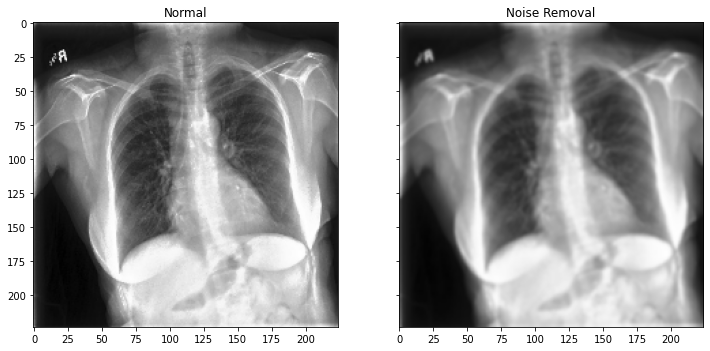

In [6]:
random_index = np.random.randint(len(train_data))

img = cv2.imread(train_data['filepaths'][random_index], cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img_denoise = cv2.GaussianBlur(img,(5,5),0)


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))

ax1.imshow(img,cmap='gray')
ax2.imshow(img_denoise,cmap='gray')

ax1.set_title('Normal')
ax2.set_title('Noise Removal')

In [7]:
data = [] 
image_size = 224 
test_pixel_data = []

for i in range(len(train_data)):
  img_array = cv2.imread(train_data['filepaths'][i], cv2.COLOR_BGR2RGB) 
  new_img_array = cv2.resize(img_array, (image_size, image_size))
  data.append([new_img_array, train_data['label'][i]])


for i in range(len(test_images)):
  img_array = cv2.imread(test_images['filepaths'][i], cv2.COLOR_BGR2RGB) 
  new_img_array = cv2.resize(img_array, (image_size, image_size))
  test_pixel_data.append(new_img_array)

In [8]:
print(len(data),len(test_pixel_data))

3479 870


In [9]:
np.random.shuffle(data)

In [10]:
x = []
y = []

for image in data:
  x.append(image[0])
  y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [11]:
np.unique(y, return_counts=True)

(array([0, 1]), array([3073,  406]))

In [12]:
print(pd.Series(y).value_counts())

0    3073
1     406
dtype: int64


In [13]:
def print_random_samples():
    index_0 = []
    index_1 = []

    for i,v in enumerate(y):
      if v == 1:
        index_1.append(i)
      else:
        index_0.append(i)

    plot_index_0 = np.random.choice(index_0)
    plot_index_1 = np.random.choice(index_1)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))

    ax1.imshow(x[plot_index_0],cmap='gray')
    ax2.imshow(x[plot_index_1],cmap='gray')

    ax1.set_title(y[plot_index_0])
    ax2.set_title(y[plot_index_1])
     

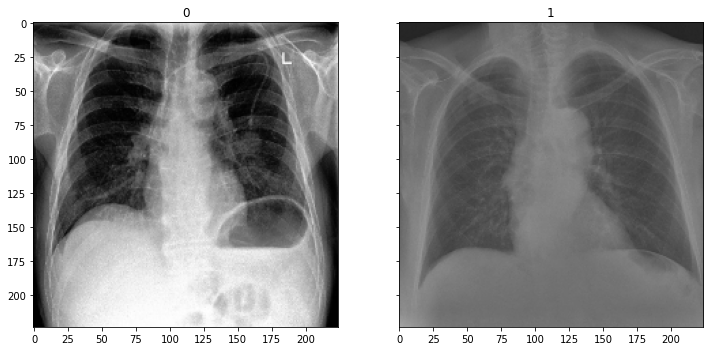

In [14]:
print_random_samples()

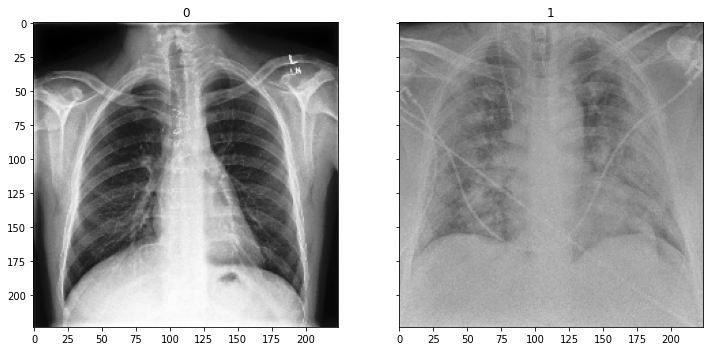

In [15]:
print_random_samples()

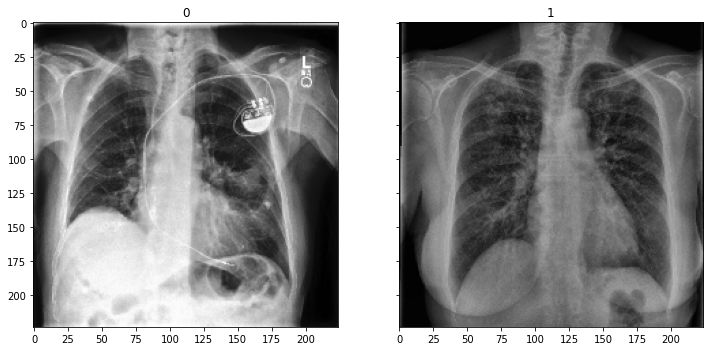

In [16]:
print_random_samples()

In [17]:
 pd.Series(y).value_counts()

0    3073
1     406
dtype: int64

In [18]:
difference = pd.Series(y).value_counts()[0] - pd.Series(y).value_counts()[1]
print(difference)

2667


## 3. Splitting the Data

In [20]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state = 42,stratify=y)

## 4. Data Pre-processing

### 4.1. Normalization

In [21]:
test_pixel_data = np.array(test_pixel_data)

test_pixel_data = test_pixel_data/255

print(X_train.shape,X_val.shape,test_pixel_data.shape)

(2783, 224, 224, 3) (696, 224, 224, 3) (870, 224, 224, 3)


In [22]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,y_train,batch_size=32)

val_generator = val_datagen.flow(X_val,y_val,batch_size=32)

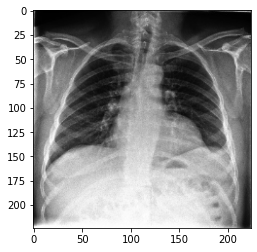

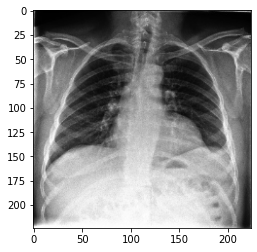

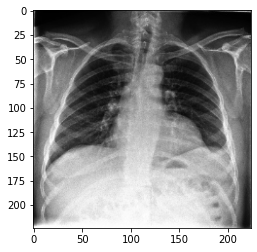

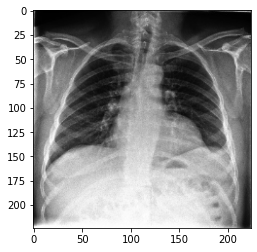

In [23]:
sample = X_train[100]
sample = np.expand_dims(sample,axis=0)
i = 0
for x1 in train_datagen.flow(sample,batch_size=1):
  plt.figure(i)
  plt.imshow(x1[0],cmap='gray')

  i+= 1
  if i%4 == 0:
    break

In [24]:
pd.Series(y_val).value_counts(normalize=True)

0    0.883621
1    0.116379
dtype: float64

In [25]:
pd.Series(y_train).value_counts(normalize=True)

0    0.88322
1    0.11678
dtype: float64

In [26]:
print(X_train.shape,X_val.shape)

(2783, 224, 224, 3) (696, 224, 224, 3)


### 4.2. EarlyStopping

In [ ]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

## 5. Building the Model

In [29]:
from keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from keras.layers import *
from keras.models import Sequential
from keras.regularizers import *
from keras.optimizers import Adam

In [30]:
# Small learning rate is used. Also a higher class weight is given to covid images since dataset is imbalanced.

def build_model():
    model = Sequential()
    
    conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    train_layers = [layer for layer in conv_base.layers[::-1][:5]]

    for layer in conv_base.layers:
      if layer in train_layers:
        layer.trainable = True
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',get_f1])
    
    return model

In [31]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 22,274,113
Trainable params: 22,037,121
Non-trainable params: 236,992
_________________________________________________________________


## 6. Training

In [32]:
model.fit(train_generator,steps_per_epoch=87,epochs=50,validation_data=val_generator,validation_steps=22,callbacks=[cbs],class_weight={0:1,1:2})

Epoch 1/50
87/87 [==============================] - 56s 644ms/step - loss: 628.2642 - accuracy: 0.7334 - get_f1: 0.4451 - val_loss: 480.9217 - val_accuracy: 0.3420 - val_get_f1: 0.2297
Epoch 2/50
87/87 [==============================] - 49s 565ms/step - loss: 361.3479 - accuracy: 0.9048 - get_f1: 0.6943 - val_loss: 252.6729 - val_accuracy: 0.7486 - val_get_f1: 0.4181
Epoch 3/50
87/87 [==============================] - 49s 565ms/step - loss: 170.8365 - accuracy: 0.9529 - get_f1: 0.8112 - val_loss: 101.0954 - val_accuracy: 0.4167 - val_get_f1: 0.2729
Epoch 4/50
87/87 [==============================] - 49s 565ms/step - loss: 55.0350 - accuracy: 0.9540 - get_f1: 0.8237 - val_loss: 21.2886 - val_accuracy: 0.9124 - val_get_f1: 0.6913
Epoch 5/50
87/87 [==============================] - 49s 563ms/step - loss: 10.1806 - accuracy: 0.9156 - get_f1: 0.7025 - val_loss: 6.3451 - val_accuracy: 0.6695 - val_get_f1: 0.3643
Epoch 6/50
87/87 [==============================] - 49s 565ms/step - loss: 2.993

## 6. Predictions

In [33]:
preds = model.predict(test_pixel_data)

In [34]:
predictions = []
for i in preds:
  if i[0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

In [35]:
result = pd.DataFrame(predictions,columns=['prediction'])

result.value_counts()

prediction
0             770
1             100
dtype: int64

In [36]:
result.to_csv('/content/drive/My Drive/DPHI COVID/denseNet201_last_five.csv',index=False)